In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchmin import minimize
import scipy.stats as stats
from scipy.stats import chi2

In [16]:
# SIMULATING THE DATA 

# PARAMETERS
num_patients = 200 # number of patients
patient_affected_prob = 0.6 # probability if patient is affected
mean_test_score = 40 # fixed intercept

noise_var = 0.1  
var_time_effect = 1.0
var_intercept = 1.0  # intercept steht für Ausgangsniveau
var_slope = 0.1 # slope steht für effektstärke / steigung

b_1 = -6.0 # effect of affected family
b_2 = 0.2 # effect of sex 
b_3 = 0.5 # effect of age

# calculating data for num_patients patients 
def simulate_data(num_patients):
    # Generate data
    data = []
    #data_we = []
    #random_intercept = D_param[0]
    #random_slope = D_param[1]
    # simuliere einen Datensatz eines Krankheitsverlauf mit infizierten und gesunden Patienten def simulate_dataset(num_patients):
    for patient_id in range(num_patients):
        # Randomly determine if family is affected
        patient_affected = np.random.choice([0, 1], p=[1-patient_affected_prob, patient_affected_prob])
    
        # Randomly determine sex
        sex = np.random.choice([0, 1], p=[0.5,0.5]) # 50/50 male or women 

        # Randomly determine age
        age = np.random.normal(40,10) # mean_age=40, age_std=10
    
        # Randomly generate time points
        num_time_points = np.random.choice([4,5,6,7,8,9,10])
        time_points = np.sort(np.random.uniform(0, 10, num_time_points))
    
        # Generate random effects
        random_intercept = np.random.normal(0.0,np.sqrt(var_intercept))
        random_slope = np.random.normal(0.0, var_slope)
        time_effects = np.random.normal(0.0, np.sqrt(var_time_effect))
        for j,t in enumerate(time_points):
            # Generate noise
            noise = np.random.normal(0.0, np.sqrt(noise_var))
        
            # Simulate test score
            test_score = mean_test_score + random_intercept + b_1 * patient_affected + b_2 * sex + b_3 * age +  time_effects * t + random_slope + noise

            data.append({'patient_id' : patient_id,
                        'years_after_treatment' : t,
                        'family_affected' :patient_affected,
                        'sex': sex,
                        'age' : age, 
                        'test_score' : test_score})
    return pd.DataFrame(data)


In [10]:
# return index of first occur of 'pat' in collumn patient_id
def get_ind(pat, df):
    return np.where(df['patient_id'] == pat)[0]

# returns a block diagonal matrix of a list of matrices
def block_diag_list(arrs_list):
    shape = torch.sum(torch.tensor([a.shape for a in arrs_list], dtype=torch.int32), dim=0)
    dtype = arrs_list[0].dtype
    device = arrs_list[0].device

    out = torch.zeros(*shape.tolist(), dtype=dtype, device=device)

    r, c = 0, 0
    for a in arrs_list:
        rows, cols = a.shape
        out[r:r + rows, c:c + cols] = a
        r += rows
        c += cols
    return out

# Random effects design matrix (Datenmatrix) for each patient
def calculate_Zlist(df, random_effects_keys):
    Z_list = [torch.cat((
        torch.ones(len(get_ind(pat, df)), 1), 
        torch.from_numpy(np.array(df.loc[get_ind(pat, df), random_effects_keys]))
                        ), -1).to(torch.float32)
                for pat in df['patient_id'].unique()]
    return Z_list

# Fixed effects design matrix (Datenmatrix) for each patient
def calculate_Xlist(df, fixed_effects_keys):
    X_list = [torch.cat((
        torch.ones(len(get_ind(pat, df)), 1), 
        torch.from_numpy(np.array(df.loc[get_ind(pat, df), fixed_effects_keys]))
                         ), -1).to(torch.float32)
                for pat in df['patient_id'].unique()]
    return X_list

def likelihood_ratio(Lmin, Lmax):
    return  2 * (Lmax - Lmin)



In [12]:
num_simulations = 50

In [18]:
#keys for random and fixed effects in the matrix
fixed_effects_keys_full = ['family_affected', 'sex', 'age']
random_effects_keys_full = ['years_after_treatment']
#keys for random and fixed effects in the matrix
fixed_effects_keys_red = ['family_affected', 'age']
random_effects_keys_red = ['years_after_treatment']
lrt_results = []


n_fixed_eff_full = len(fixed_effects_keys_full) + 1
n_rand_eff_full = len(random_effects_keys_full) + 1
n_fixed_eff_red = len(fixed_effects_keys_red) + 1
n_rand_eff_red = len(random_effects_keys_red) + 1
softplus = torch.nn.Softplus()

for sim in range(num_simulations):
    print(f"Epoch: {sim}")
    print("\nTrain full model")
    df = simulate_data(200)
    N = len(df)

    # Random effects design matrix (Datenmatrix) for each patient
    Z_list_full = calculate_Zlist(df, random_effects_keys_full)

    # Fixed effects design matrix (Datenmatrix) for each patient
    X_list_full = calculate_Xlist(df, fixed_effects_keys_full)

    # Response variable: Test scores
    y_full = torch.from_numpy(np.array(df['test_score'])).to(torch.float32)

    # Learnable parameter for diagonal covariance matrix
    D_param_full = torch.randn(n_rand_eff_full, requires_grad=True)


    # Defining list of X tilde (eq. 2.7 p. 63)
    X_tilde_list_full = [torch.cat((X_i, torch.zeros((n_rand_eff_full, n_fixed_eff_full)))) for X_i in X_list_full]
    # Augmented response vector y_e (eq. 2.11 p. 65)
    y_e_full = torch.cat([torch.cat((y_full[get_ind(pat, df)], torch.zeros(n_rand_eff_full))).unsqueeze(-1) for pat in df['patient_id'].unique()])


    def calculate_likelihood(D_param_full): 
        # Ensure that the diagonal covariance matrix has only positive values
        Delta = torch.diag(softplus(D_param_full))
        det_Delta = torch.det(Delta)  

        # Defining list of Z tilde (eq. 2.7 p. 63)
        Z_tilde_list = [torch.cat((Z_i, Delta)) for Z_i in Z_list_full]
        # Matrix X_e (eq. 2.11 p. 65)
        X_e = torch.cat((block_diag_list(Z_tilde_list), torch.cat(X_tilde_list_full)), -1)

        # Calculate MLE estimates of random and fixed effects with current set of covariance Parameters (eq. 2.11 p. 65)
        pred = torch.inverse((X_e.t() @ X_e)) @ X_e.t() @ y_e_full
        # Calculate MLE estimates of the noise sigma with current set of covariance Parameters (eq. 2.12 p. 65)
        pred_sigma = torch.sum((y_e_full - X_e @ pred) ** 2) / N

        # Calculate the logarithm of the likelihood function in (eq. 2.13 p. 65)
        likelihood = -N/2 * (1 + torch.log(torch.tensor(2 * torch.pi)) + torch.log(pred_sigma))
        likelihood += torch.log(torch.stack([det_Delta/torch.det(Z_i_tilde.t() @ Z_i_tilde).sqrt() for Z_i_tilde in Z_tilde_list])).sum()
        # print(f"Likelihood: {round(likelihood.item(), 2)}, est. noise: {round(pred_sigma.item(), 3)}, est. fixed intercept: {round(pred[-n_fixed_eff_full].detach().item(), 3)}, "+ \
        #     ", ".join([f"est. {fixed_effects_keys_full[i]}: {round(pred[-n_fixed_eff_full+i+1].detach().item(), 3)}" for i in range(len(fixed_effects_keys_full))]))
        return - likelihood

    # Minimize the log-likelihood with 2nd order optimizer
    result_full = minimize(calculate_likelihood, D_param_full, method='bfgs', max_iter=6)
    loglikelihood_full = result_full.fun

    print("\nTrain reduced model")
    # Random effects design matrix (Datenmatrix) for each patient
    Z_list_red = calculate_Zlist(df, random_effects_keys_red)

    # Fixed effects design matrix (Datenmatrix) for each patient
    X_list_red = calculate_Xlist(df, fixed_effects_keys_red)

    # Response variable: Test scores
    y_red = torch.from_numpy(np.array(df['test_score'])).to(torch.float32)

    # Learnable parameter for diagonal covariance matrix
    D_param_red = torch.randn(n_rand_eff_red, requires_grad=True)


    # Defining list of X tilde (eq. 2.7 p. 63)
    X_tilde_list_red = [torch.cat((X_i, torch.zeros((n_rand_eff_red, n_fixed_eff_red)))) for X_i in X_list_red]
    # Augmented response vector y_e (eq. 2.11 p. 65)
    y_e_red = torch.cat([torch.cat((y_red[get_ind(pat, df)], torch.zeros(n_rand_eff_red))).unsqueeze(-1) for pat in df['patient_id'].unique()])


    def calculate_likelihood(D_param_red): 
        # Ensure that the diagonal covariance matrix has only positive values
        Delta = torch.diag(softplus(D_param_red))
        det_Delta = torch.det(Delta)  

        # Defining list of Z tilde (eq. 2.7 p. 63)
        Z_tilde_list = [torch.cat((Z_i, Delta)) for Z_i in Z_list_red]
        # Matrix X_e (eq. 2.11 p. 65)
        X_e = torch.cat((block_diag_list(Z_tilde_list), torch.cat(X_tilde_list_red)), -1)

        # Calculate MLE estimates of random and fixed effects with current set of covariance Parameters (eq. 2.11 p. 65)
        pred = torch.inverse((X_e.t() @ X_e)) @ X_e.t() @ y_e_red
        # Calculate MLE estimates of the noise sigma with current set of covariance Parameters (eq. 2.12 p. 65)
        pred_sigma = torch.sum((y_e_red - X_e @ pred) ** 2) / N

        # Calculate the logarithm of the likelihood function in (eq. 2.13 p. 65)
        likelihood = -N/2 * (1 + torch.log(torch.tensor(2 * torch.pi)) + torch.log(pred_sigma))
        likelihood += torch.log(torch.stack([det_Delta/torch.det(Z_i_tilde.t() @ Z_i_tilde).sqrt() for Z_i_tilde in Z_tilde_list])).sum()
        # print(f"Likelihood: {round(likelihood.item(), 2)}, est. noise: {round(pred_sigma.item(), 3)}, est. fixed intercept: {round(pred[-n_fixed_eff_red].detach().item(), 3)}, "+ \
        #     ", ".join([f"est. {fixed_effects_keys_red[i]}: {round(pred[-n_fixed_eff_red+i+1].detach().item(), 3)}" for i in range(len(fixed_effects_keys_red))]))
        return - likelihood

    # Minimize the log-likelihood with 2nd order optimizer
    result_reduced = minimize(calculate_likelihood, D_param_red, method='bfgs', max_iter=6)
    loglikelihood_red = result_reduced.fun

    #likelihood_df = calculate_likelihood(D_param)
    lrt_val = likelihood_ratio(loglikelihood_red, loglikelihood_full)
    print(f"LRT Value: {lrt_val}")
    lrt_results.append(lrt_val)


Epoch: 0

Train full model

Train reduced model
LRT Value: -7.1044921875
Epoch: 1

Train full model

Train reduced model
LRT Value: -0.83544921875
Epoch: 2

Train full model

Train reduced model
LRT Value: -3.970458984375
Epoch: 3

Train full model

Train reduced model
LRT Value: -4.197998046875
Epoch: 4

Train full model

Train reduced model
LRT Value: -9.650634765625
Epoch: 5

Train full model

Train reduced model
LRT Value: -1.852783203125
Epoch: 6

Train full model

Train reduced model
LRT Value: -2.53369140625
Epoch: 7

Train full model

Train reduced model
LRT Value: -0.573486328125
Epoch: 8

Train full model

Train reduced model
LRT Value: 9.1201171875
Epoch: 9

Train full model

Train reduced model
LRT Value: -1.146240234375
Epoch: 10

Train full model

Train reduced model
LRT Value: -1.834716796875
Epoch: 11

Train full model

Train reduced model
LRT Value: 8.396484375
Epoch: 12

Train full model

Train reduced model
LRT Value: 1.67578125
Epoch: 13

Train full model

Train red

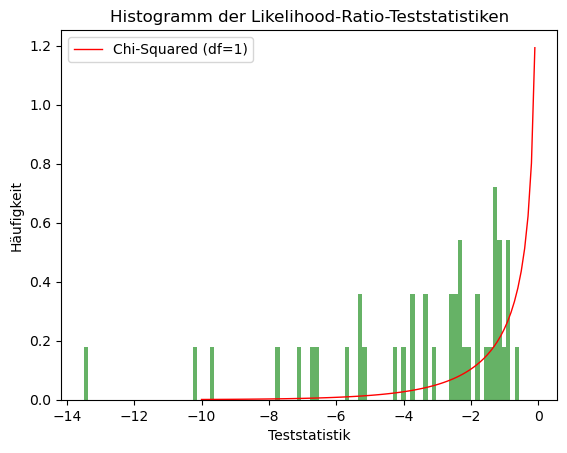

In [20]:

lrt_hist = []
for res in lrt_results:
    if  -50 < res < 0:
        lrt_hist.append(res)

# Histogramm der Teststatistiken erstellen
#plt.hist(lrt_results, bins=50, density=True, alpha=0.6, color='g')

plt.hist(np.array(torch.stack(lrt_hist).detach()), bins=100, density=True, alpha=0.6, color='g')

# Chi-Quadrat-Verteilung mit einem Freiheitsgrad plotten (für Vergleich)
x = np.linspace(0, 10, 100)
plt.plot(-x, chi2.pdf(x, df=1), 'r-', lw=1, label='Chi-Squared (df=1)')


# Beschriftungen hinzufügen
plt.title('Histogramm der Likelihood-Ratio-Teststatistiken')
plt.xlabel('Teststatistik')
plt.ylabel('Häufigkeit')
plt.legend()

# Histogramm anzeigen
plt.show()

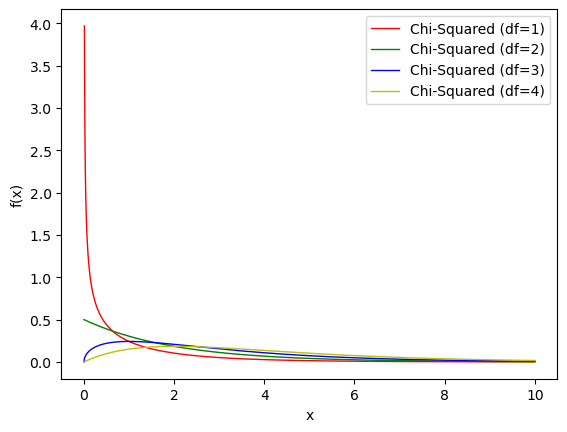

In [ ]:
x = np.linspace(0, 10, 1000)
plt.plot(x, chi2.pdf(x, df=1), 'r-', lw=1, label='Chi-Squared (df=1)')
plt.plot(x, chi2.pdf(x, df=2), 'g-', lw=1, label='Chi-Squared (df=2)')
plt.plot(x, chi2.pdf(x, df=3), 'b-', lw=1, label='Chi-Squared (df=3)')
plt.plot(x, chi2.pdf(x, df=4), 'y-', lw=1, label='Chi-Squared (df=4)')
# Beschriftungen hinzufügen
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

# Histogramm anzeigen
plt.show()